# 1. Getting the Data

First we will scrape policies from the gov.ie website.

In your command line, ``cd`` into this repository.

``cd`` into the ``policy_scraping`` task directory, then ``cd`` again into the ``policy_scraping`` scrapy environment.

In [1]:
import os, json
cwd = os.getcwd() # should be base directory of repository
os.chdir(cwd+"/policy_scraping/policy_scraping")

Run ``scrapy crawl goviefor -O ../outputs/goviefor.json`` (or you can change the -O argument to whatever you would prefer the output file information to be).

This command will generate a json containing the metadata about all the policies as well as download all files to the same outputs directory under ``forestry/full``.

In [ ]:
!! scrapy crawl goviefor -O ../outputs/goviefor.json

Next we will consolidate the metadata and text of the policy PDFs into one dictionary.

In [2]:
os.chdir(cwd) # back to base directory
import json
from populate_corpora.pdfs_to_jsons import scrp_itm_to_fulltxt
FILE_DIR= cwd+"/policy_scraping/policy_scraping/outputs" # or whatever output directory you gave the scraper for its output json

In [2]:
with open(cwd+"/policy_scraping/outputs/goviefor.json","r", encoding="utf-8") as f:
    metad = json.load(f)
pdf_dict = scrp_itm_to_fulltxt(metad, FILE_DIR+"/forestry/full")

NameError: name 'scrp_itm_to_fulltxt' is not defined

If you have your own collection of pdfs to process and don't have a metadata file, you can use this next function on just the file directory.

In [ ]:
from populate_corpora.pdfs_to_jsons import pdfs_to_txt_dct
pdf_dict = pdfs_to_txt_dct(FILE_DIR+"/forestry/full") # or whatever your policy directory is

For the purposes of this project, we only want the texts of the PDFs in cleaned sentences anyways. So we'll go ahead and extract/clean those sentences, then load them into the dictionary format that doccano (labeling platform) uses. Finally, if we want, we can use a simple keyword search to prelabel some of the sentences with a "incentive class mention" label.

In [ ]:
import nltk
from populate_corpora.data_cleaning import get_clean_text_sents, format_sents_for_doccano, prelabeling
EN_TOKENIZER = nltk.data.load("tokenizers/punkt/english.pickle") # need tokenizer for our text cleaning
clean_sents= get_clean_text_sents(pdf_dict, EN_TOKENIZER)
doccano_dict = format_sents_for_doccano(clean_sents)
prelab_doccano_dict = prelabeling(doccano_dict)

Now we can download this dictionary as a json to import into our doccano instance for labeling.

In [ ]:
with open(cwd+"/populate_corpora/outputs/ready_to_label.json", 'w', encoding="utf-8") as outfile:
    json.dump(prelab_doccano_dict, outfile, ensure_ascii=False, indent=4)

# 2. Labeling the Data

## Augmentation via Sentence Similarity Search

We also need to make a new human-in-the-loop dataset using by doing sentence similarity searches with predefined queries. We have five queries for each label.

In [11]:
with open(cwd+"/populate_corpora/outputs/ready_to_label.json","r", encoding="utf-8") as f:
    prelab_doccano_dict = json.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\allie\\Documents\\GitHub\\policy-classifier/populate_corpora/outputs/ready_to_label.json'

In [ ]:
from populate_corpora.query_augment import run_embedder, run_queries, QUERIES_DCT
from populate_corpora.data_cleaning import dcno_to_only_sents

# loading all sentences, not just the labeled ones
# or reload cwd+"/populate_corpora/outputs/ready_to_label.json"
all_sents = dcno_to_only_sents(prelab_doccano_dict) 
embs, s_sentences, model = run_embedder(sample=False, dev='cuda', data=all_sents, unique=True)
# uses our queries dictionary, but obvs you can make your own
qry_dct = run_queries(embs, s_sentences, model, qry_dct=QUERIES_DCT, dev='cuda', sim_thresh=0.5, res_lim=1000)

NameError: name 'prelab_doccano_dict' is not defined

Now we'll parse the results and create a dataset of sentences labeled by the query process, but we first need to filter them to only include sentences found by at least 4/5 queries for each label.

In [ ]:
from populate_corpora.query_augment import consolidate_sents, crossref_sents
lbl_qry_dct = consolidate_sents(qry_dct, QUERIES_DCT)
filt_qry_dct = crossref_sents(lbl_qry_dct, 4)
qry_rs_dataset = [{'text': sent, 'label': lbl} for lbl in list(filt_qry_dct) for sent in filt_qry_dct[lbl]]

In [ ]:
with open(cwd+"/populate_corpora/outputs/augmented_to_label.json", 'w', encoding="utf-8") as outfile:
    json.dump(qry_rs_dataset, outfile, ensure_ascii=False, indent=4)

## External Annotation

We used a doccano instance for our labeling, but we also had to do some data validation with an external annotator. This section generates a subset for a labeler from the hand-labeled dataset.

In [3]:
from populate_corpora.annotators import resample_forannot
from populate_corpora.data_cleaning import dcno_to_sentlab, remove_duplicates, group_duplicates
with open(cwd+"/inputs/19Jan25_firstdatarev.json","r", encoding="utf-8") as f:
    dcno_json = json.load(f)
with open(cwd+"/inputs/27Jan25_query_checked.json","r", encoding="utf-8") as f:
    qry_json = json.load(f)
sents1, labels1 = dcno_to_sentlab(dcno_json)
sents2, labels2 = dcno_to_sentlab(qry_json)
sents3 = sents1+sents2
labels3 = labels1+labels2
all_sents, all_labs = remove_duplicates(group_duplicates(sents3,labels3,thresh=90))

1419 groups found with a threshold of 90
Sanity check: 1419 sentences and 1419 labels


In [10]:
ann_sents, ann_labels = resample_forannot(all_sents, all_labs, 0.3, 0.5)
print(round(len(ann_sents)/len(all_sents), 3))

Counter({'Non-Incentive': 1150, 'Supplies': 81, 'Technical_assistance': 75, 'Direct_payment': 62, 'Fine': 23, 'Credit': 19, 'Tax_deduction': 9})
Counter({'Supplies': 81, 'Technical_assistance': 75, 'Direct_payment': 62, 'Fine': 23, 'Credit': 19, 'Tax_deduction': 9})
Counter({'Supplies': 24, 'Technical_assistance': 22, 'Direct_payment': 19, 'Fine': 7, 'Credit': 6, 'Tax_deduction': 3})
Counter({'Non-Incentive': 81, 'Supplies': 24, 'Technical_assistance': 22, 'Direct_payment': 19, 'Fine': 7, 'Credit': 6, 'Tax_deduction': 3})
Should be true: True
162 162
0.114


In [13]:
import random
ann_frame = [{'text':ann_sents[i], 'label':[]} for i in range(len(ann_labels))]
random.shuffle(ann_frame)
with open(cwd+"/inputs/subsample.json", 'w', encoding="utf-8") as outfile:
    json.dump(ann_frame, outfile, ensure_ascii=False, indent=4)
val_frame = [{'text':ann_sents[i], 'label':ann_labels[i]} for i in range(len(ann_labels))]
with open(cwd+"/inputs/subsample_key.json", 'w', encoding="utf-8") as outfile:
    json.dump(val_frame, outfile, ensure_ascii=False, indent=4)

Now let's check the inter-annotator agreement.

In [4]:
with open(cwd+"/inputs/yw_annot.json","r", encoding="utf-8") as f: #our hand-labeled dataset
    ann_json = json.load(f)
with open(cwd+"/inputs/subsample_key.json","r", encoding="utf-8") as f:
    key_json = json.load(f)

sents_k = [entry["text"] for entry in key_json]
labels_k = [entry["label"] for entry in key_json]
sents_a, labels_a = dcno_to_sentlab(ann_json)
# correct labels
sents_a2, labels_a2 = [], []
for i, lab in enumerate(labels_a):
  try:
    if lab == 'non-incentive':
      labels_a2.append('Non-Incentive')
    else:
      labels_a2.append(lab)
    sents_a2.append(sents_a[i])
  except:
    pass


In [5]:
from populate_corpora.annotators import get_common_sentlabs, all_to_bin, all_to_sharedmc
from sklearn.metrics import cohen_kappa_score

s_sents, labels_sc, labels_sa = get_common_sentlabs(sents_k, labels_k, sents_a2, labels_a2)
#print(f"All: {cohen_kappa_score(labels_sc, labels_sa)} for {len(labels_sc)} entries")

labs_binc, labs_bina = all_to_bin(labels_sc), all_to_bin(labels_sa)
print(f"Binary: {cohen_kappa_score(labs_binc, labs_bina)} for {len(labs_binc)} entries")

mclabsc, mclaba = all_to_sharedmc(labels_sc, labels_sa, labs_binc, labs_bina)
print(f"Multiclass: {cohen_kappa_score(mclabsc, mclaba)} for {len(mclabsc)} entries")

print(f"All: {cohen_kappa_score(labels_sc, labels_sa)} for {len(labels_sc)} entries")

Binary: 0.6308119361554476 for 152 entries
Multiclass: 0.85880195599022 for 66 entries
All: 0.6750946622694516 for 152 entries


## Consolidation into Final Dataset

We now have all of our data labeled, so it is time to create a final dataset broken into training and testing sets.

In [6]:
import os, json
cwd = os.getcwd()
os.chdir(cwd)
from populate_corpora.data_cleaning import dcno_to_sentlab
from classifier.run_classifiers import group_duplicates, remove_duplicates

with open(cwd+"/inputs/19Jan25_firstdatarev.json","r", encoding="utf-8") as f: #our hand-labeled dataset
    dcno_json = json.load(f)
with open(cwd+"/inputs/27Jan25_query_checked.json","r", encoding="utf-8") as f: #our human-in-the-loop dataset
    aug_json = json.load(f)

sents_d, labels_d = dcno_to_sentlab(dcno_json)
sents_a, labels_a = dcno_to_sentlab(aug_json)

all_sents = sents_d+sents_a
all_labs = labels_d+labels_a
sentences, labels = remove_duplicates(group_duplicates(all_sents,all_labs,thresh=90))

1419 groups found with a threshold of 90
Sanity check: 1419 sentences and 1419 labels


In [46]:
print(len(sents_d))
print(len(sents_a))

965
626


In [3]:
from classifier.run_classifiers import gen_bn_sentlab, gen_mc_sentlab

bn_sents, bn_labels = gen_bn_sentlab(sentences, labels)
mc_sents, mc_labels = gen_mc_sentlab(sentences, labels)

Sanity Check: 269 incentive sentences and 1150 non-incentive sentences
Incentives: 0.18957011980267793; Non-Incentives: 0.8104298801973221
Sanity Check: 269 incentive sentences and 269 incentive labels


In [8]:
import matplotlib.pyplot as plt
import numpy as np
#plt.style.use('_mpl-gallery-nogrid')
plt.rcParams['font.family'] = ["monospace"]
plt.rcParams['font.size'] = 12

bn_colors = plt.get_cmap()(np.linspace(0.5, 0.9, 2))
num_non = bn_labels.count("non-incentive")
num_inc = bn_labels.count("incentive")

fig, ax = plt.subplots()
ax.pie([num_non, num_inc], colors=bn_colors, labels=["Non-incentive", "Incentive"], autopct='%1.1f%%', radius=1.25,
       wedgeprops={"linewidth": 1, "edgecolor": "white"})
fig.show()

NameError: name 'bn_labels' is not defined

C:\Users\allie\AppData\Local\Temp\ipykernel_37600\4055259558.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


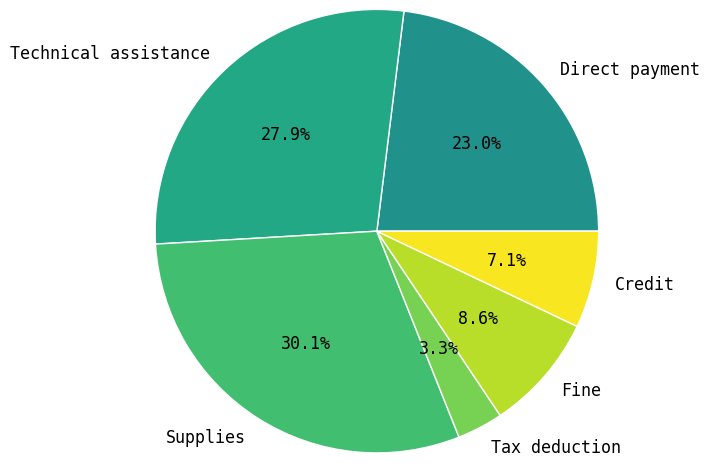

In [43]:
num_dp = mc_labels.count("Direct_payment")
num_ta = mc_labels.count("Technical_assistance")
num_su = mc_labels.count("Supplies")
num_td = mc_labels.count("Tax_deduction")
num_fn = mc_labels.count("Fine")
num_cr = mc_labels.count("Credit")

mc_colors = plt.get_cmap()(np.linspace(0.5, 0.99, 6))

fig, ax = plt.subplots()
ax.pie([num_dp, num_ta, num_su, num_td, num_fn, num_cr], labels=["Direct payment", "Technical assistance", "Supplies", "Tax deduction", "Fine", "Credit"], colors=mc_colors, autopct='%1.1f%%', radius=1.5,
       wedgeprops={"linewidth": 1, "edgecolor": "white"})
fig.show()

C:\Users\allie\AppData\Local\Temp\ipykernel_17576\2609736636.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


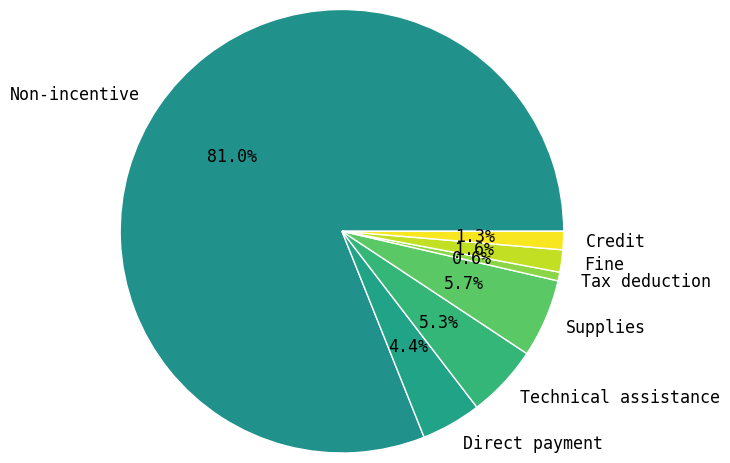

In [12]:
num_dp = labels.count("Direct_payment")
num_ta = labels.count("Technical_assistance")
num_su = labels.count("Supplies")
num_td = labels.count("Tax_deduction")
num_fn = labels.count("Fine")
num_cr = labels.count("Credit")
num_ni = labels.count("Non-Incentive")

mc_colors = plt.get_cmap()(np.linspace(0.5, 0.99, 7))

fig, ax = plt.subplots()
ax.pie([num_ni, num_dp, num_ta, num_su, num_td, num_fn, num_cr], labels=["Non-incentive", "Direct payment", "Technical assistance", "Supplies", "Tax deduction", "Fine", "Credit"], colors=mc_colors, autopct='%1.1f%%', radius=1.5,
       wedgeprops={"linewidth": 1, "edgecolor": "white"})
fig.show()

# 3. Fine-Tuning Our Models

First we will construct and save a few different splits of our data into DatasetDicts containing Training, Testing, and Holdout sets.

In [4]:
from classifier.finetune import load_labelintdcts, create_dsdict
int2label_dct, label2int_dct = load_labelintdcts()
sims = [0,3,6,9]
create_dsdict(sentences, labels, label2int_dct, amt=sims, save=True, output_dir=f"{cwd}/outputs/models")

Sanity Check: 269 incentive sentences and 1150 non-incentive sentences
Incentives: 0.18957011980267793; Non-Incentives: 0.8104298801973221
Sanity Check: 269 incentive sentences and 269 incentive labels

Round 0



Saving the dataset (0/1 shards):   0%|          | 0/851 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saved ds_0_bn


Saving the dataset (0/1 shards):   0%|          | 0/161 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/54 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/54 [00:00<?, ? examples/s]

Saved ds_0_mc

Round 3



Saving the dataset (0/1 shards):   0%|          | 0/851 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saved ds_3_bn


Saving the dataset (0/1 shards):   0%|          | 0/161 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/54 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/54 [00:00<?, ? examples/s]

Saved ds_3_mc

Round 6



Saving the dataset (0/1 shards):   0%|          | 0/851 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saved ds_6_bn


Saving the dataset (0/1 shards):   0%|          | 0/161 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/54 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/54 [00:00<?, ? examples/s]

Saved ds_6_mc

Round 9



Saving the dataset (0/1 shards):   0%|          | 0/851 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saved ds_9_bn


Saving the dataset (0/1 shards):   0%|          | 0/161 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/54 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/54 [00:00<?, ? examples/s]

Saved ds_9_mc


In [3]:
import torch
from classifier.finetune import finetune_roberta
from datasets import DatasetDict
output_dir = cwd+"/outputs/models_rob_lora"

We will run our finetuning, training the whole model.

In [ ]:
from classifier.finetune import load_labelintdcts
int2label_dct, label2int_dct = load_labelintdcts()
sims = [0,3,6,9]
for e in sims:
    bn_ds = DatasetDict.load_from_disk(f"{output_dir}/../models/ds_{e}_bn")
    mc_ds = DatasetDict.load_from_disk(f"{output_dir}/../models/ds_{e}_mc")
    for model in ["sentence-transformers/paraphrase-xlm-r-multilingual-v1"]:
        torch.cuda.empty_cache()
        finetune_roberta(bn_ds, int2label_dct["bn"], label2int_dct["bn"], "bn", model_name=model, dev='cuda', rstate=e, output_dir=output_dir, lora=False)
        print(f"\nSaved {model} binary model.")
        torch.cuda.empty_cache()
        finetune_roberta(mc_ds, int2label_dct["mc"], label2int_dct["mc"], "mc", model_name=model, dev='cuda', rstate=e, output_dir=output_dir, lora=False)
        print(f"\nSaved {model} multiclass model.")


Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing
Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.403192,0.809859,0.894942
2,No log,0.351877,0.813380,0.896686
3,No log,0.267847,0.887324,0.933054
4,No log,0.256317,0.890845,0.933045
5,No log,0.412621,0.880282,0.929167
6,No log,0.397599,0.887324,0.932203
7,No log,0.413806,0.894366,0.935065
8,No log,0.453075,0.887324,0.930435
9,No log,0.468151,0.880282,0.925764
10,0.163500,0.485296,0.887324,0.931034


Saving


{'accuracy': 0.8345070422535211, 'f1': 0.8962472406181015}

Saved paraphrase-xlm-r-multilingual-v1_bn_e10_r0.

Done in 8.35 min

Saved sentence-transformers/paraphrase-xlm-r-multilingual-v1 binary model.

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/54 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model
Training


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.704223,0.314815,0.257355
2,No log,1.568436,0.425926,0.372486
3,No log,1.473549,0.500000,0.425075
4,No log,1.412705,0.574074,0.509884
5,No log,1.357442,0.611111,0.546075
6,No log,1.298182,0.648148,0.576853
7,No log,1.243423,0.666667,0.597355
8,No log,1.202564,0.685185,0.612842
9,No log,1.178162,0.685185,0.612842
10,No log,1.170743,0.685185,0.612842


Saving


{'accuracy': 0.7222222222222222, 'f1': 0.6627902704291594}

Saved paraphrase-xlm-r-multilingual-v1_mc_e10_r0.

Done in 4.08 min

Saved sentence-transformers/paraphrase-xlm-r-multilingual-v1 multiclass model.

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/284 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.399787,0.809859,0.894942
2,No log,0.339749,0.813380,0.896686
3,No log,0.314648,0.862676,0.915033
4,No log,0.334698,0.834507,0.892449
5,No log,0.467116,0.802817,0.866029
6,No log,0.420797,0.887324,0.930131
7,No log,0.509341,0.841549,0.897959
8,No log,0.440672,0.897887,0.936819
9,No log,0.471673,0.887324,0.929825
10,0.166300,0.490897,0.869718,0.917595


Saving


{'accuracy': 0.8908450704225352, 'f1': 0.9330453563714903}

Saved paraphrase-xlm-r-multilingual-v1_bn_e10_r3.

Done in 8.1 min

Saved sentence-transformers/paraphrase-xlm-r-multilingual-v1 binary model.

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/54 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model
Training


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.686889,0.333333,0.205387
2,No log,1.538742,0.407407,0.294323
3,No log,1.433668,0.481481,0.381318
4,No log,1.351844,0.574074,0.496311
5,No log,1.298502,0.611111,0.554622
6,No log,1.228000,0.685185,0.641732
7,No log,1.176806,0.759259,0.714427
8,No log,1.133558,0.759259,0.714427
9,No log,1.110592,0.759259,0.714427
10,No log,1.100270,0.759259,0.714427


Saving


{'accuracy': 0.7037037037037037, 'f1': 0.6541819179014302}

Saved paraphrase-xlm-r-multilingual-v1_mc_e10_r3.

Done in 3.7 min

Saved sentence-transformers/paraphrase-xlm-r-multilingual-v1 multiclass model.

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/284 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model
Training


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.421656,0.809859,0.894942
2,No log,0.337635,0.823944,0.901575
3,No log,0.391819,0.838028,0.907631
4,No log,0.285107,0.883803,0.929032
5,No log,0.347155,0.866197,0.914798
6,No log,0.373236,0.883803,0.926829
7,No log,0.466914,0.852113,0.904977
8,No log,0.440431,0.883803,0.927152
9,No log,0.444365,0.883803,0.927473
10,0.174100,0.450138,0.883803,0.927473


Saving


{'accuracy': 0.8697183098591549, 'f1': 0.9197396963123645}

Saved paraphrase-xlm-r-multilingual-v1_bn_e10_r6.

Done in 9.05 min

Saved sentence-transformers/paraphrase-xlm-r-multilingual-v1 binary model.

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/54 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model
Training


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.667879,0.314815,0.194398
2,No log,1.519349,0.314815,0.192308
3,No log,1.435200,0.462963,0.371693
4,No log,1.360883,0.574074,0.509259
5,No log,1.282021,0.666667,0.596692
6,No log,1.205178,0.666667,0.596692
7,No log,1.144576,0.703704,0.631961
8,No log,1.101119,0.740741,0.684718
9,No log,1.076036,0.722222,0.668904
10,No log,1.066734,0.722222,0.668904


Saving


{'accuracy': 0.7592592592592593, 'f1': 0.6972993827160494}

Saved paraphrase-xlm-r-multilingual-v1_mc_e10_r6.

Done in 3.66 min

Saved sentence-transformers/paraphrase-xlm-r-multilingual-v1 multiclass model.

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/284 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.417651,0.809859,0.894942
2,No log,0.347938,0.813380,0.896686
3,No log,0.444175,0.838028,0.907258
4,No log,0.327923,0.866197,0.915929
5,No log,0.431086,0.883803,0.929638
6,No log,0.449658,0.876761,0.924731
7,No log,0.476099,0.883803,0.929336
8,No log,0.504193,0.887324,0.931330
9,No log,0.509247,0.883803,0.928726
10,0.148800,0.513553,0.887324,0.931330


Saving


{'accuracy': 0.8204225352112676, 'f1': 0.8859060402684564}

Saved paraphrase-xlm-r-multilingual-v1_bn_e10_r9.

Done in 8.95 min

Saved sentence-transformers/paraphrase-xlm-r-multilingual-v1 binary model.

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/54 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model
Training


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.680893,0.518519,0.404762
2,No log,1.504356,0.666667,0.595607
3,No log,1.375719,0.685185,0.610093
4,No log,1.286656,0.666667,0.601699
5,No log,1.201035,0.685185,0.612922
6,No log,1.119415,0.703704,0.644973
7,No log,1.047340,0.722222,0.666769
8,No log,1.003747,0.722222,0.666769
9,No log,0.979431,0.722222,0.666769
10,No log,0.968481,0.722222,0.666769


Saving


{'accuracy': 0.8518518518518519, 'f1': 0.8029482473926919}

Saved paraphrase-xlm-r-multilingual-v1_mc_e10_r9.

Done in 4.08 min

Saved sentence-transformers/paraphrase-xlm-r-multilingual-v1 multiclass model.


Now we'll evaluate our models using both the model classification heads and SVM classifiers based on model embeddings.

In [ ]:
from classifier.ft_classification import run_experiments, modelpred_dsdct_clsf, svm_dsdct_clsf
from classifier.run_classifiers import res_dct_to_cls_rpt, cls_rpt_to_exp_rpt
from classifier.finetune import load_labelintdcts
int2label_dct, label2int_dct = load_labelintdcts()
outfn = "6Apr25"
model_results_dict, svm_results_dict = run_experiments(int2label_dct, label2int_dct, f"{cwd}/outputs/models", output_dir, cuda=True)
with open(f"{output_dir}/randp_{outfn}_model.json", 'w', encoding="utf-8") as outfile:
    json.dump(model_results_dict, outfile, ensure_ascii=False, indent=4)
with open(f"{output_dir}/randp_{outfn}_svm.json", 'w', encoding="utf-8") as outfile:
    json.dump(svm_results_dict, outfile, ensure_ascii=False, indent=4)
mdl_cls_rpt = res_dct_to_cls_rpt(model_results_dict, int2label_dct)
mdl_exp_rpt = cls_rpt_to_exp_rpt(mdl_cls_rpt)
with open(f"{output_dir}/exprpt_{outfn}_mdl.json", 'w', encoding="utf-8") as outfile:
    json.dump(mdl_exp_rpt, outfile, ensure_ascii=False, indent=4)
svm_cls_rpt = res_dct_to_cls_rpt(svm_results_dict, int2label_dct)
svm_exp_rpt = cls_rpt_to_exp_rpt(svm_cls_rpt)
with open(f"{output_dir}/exprpt_{outfn}_svm.json", 'w', encoding="utf-8") as outfile:
    json.dump(svm_exp_rpt, outfile, ensure_ascii=False, indent=4)

# add parameter for model location?/datasetdict location in ft classification from below error
# add parameter for checking if label is int or str in run classifiers processing results


['bert_bn_e10_r0', 'bert_mc_e10_r0', 'bert_bn_e10_r3', 'bert_mc_e10_r3', 'bert_bn_e10_r6', 'bert_mc_e10_r6', 'bert_bn_e10_r9', 'bert_mc_e10_r9']

Running model bert_bn_e10_r0
Loading tokenizer
Loading model
Running model


100%|██████████| 9/9 [00:03<00:00,  2.97it/s]


Freeing memory


No sentence-transformers model found with name c:\Users\allie\Documents\GitHub\policy-classifier/outputs/models_lr1e5/paraphrase-xlm-r-multilingual-v1_bn_e10_r0.pt. Creating a new one with mean pooling.
Some weights of XLMRobertaModel were not initialized from the model checkpoint at c:\Users\allie\Documents\GitHub\policy-classifier/outputs/models_lr1e5/paraphrase-xlm-r-multilingual-v1_bn_e10_r0.pt and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1135/1135 [00:15<00:00, 74.12it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:04<00:00, 70.50it/s]


bert_bn_e10_r0 run completed in in 27.3s

Running model bert_mc_e10_r0
Loading tokenizer
Loading model
Running model


100%|██████████| 2/2 [00:00<00:00,  2.58it/s]


Freeing memory


No sentence-transformers model found with name c:\Users\allie\Documents\GitHub\policy-classifier/outputs/models_lr1e5/paraphrase-xlm-r-multilingual-v1_mc_e10_r0.pt. Creating a new one with mean pooling.
Some weights of XLMRobertaModel were not initialized from the model checkpoint at c:\Users\allie\Documents\GitHub\policy-classifier/outputs/models_lr1e5/paraphrase-xlm-r-multilingual-v1_mc_e10_r0.pt and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 215/215 [00:03<00:00, 61.96it/s]


Encoding test sentences.


100%|██████████| 54/54 [00:00<00:00, 57.90it/s]


bert_mc_e10_r0 run completed in in 10.18s

Running model bert_bn_e10_r3
Loading tokenizer
Loading model
Running model


100%|██████████| 9/9 [00:04<00:00,  2.13it/s]


Freeing memory


No sentence-transformers model found with name c:\Users\allie\Documents\GitHub\policy-classifier/outputs/models_lr1e5/paraphrase-xlm-r-multilingual-v1_bn_e10_r3.pt. Creating a new one with mean pooling.
Some weights of XLMRobertaModel were not initialized from the model checkpoint at c:\Users\allie\Documents\GitHub\policy-classifier/outputs/models_lr1e5/paraphrase-xlm-r-multilingual-v1_bn_e10_r3.pt and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1135/1135 [00:16<00:00, 67.53it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:04<00:00, 60.12it/s]


bert_bn_e10_r3 run completed in in 31.2s

Running model bert_mc_e10_r3
Loading tokenizer
Loading model
Running model


100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Freeing memory


No sentence-transformers model found with name c:\Users\allie\Documents\GitHub\policy-classifier/outputs/models_lr1e5/paraphrase-xlm-r-multilingual-v1_mc_e10_r3.pt. Creating a new one with mean pooling.
Some weights of XLMRobertaModel were not initialized from the model checkpoint at c:\Users\allie\Documents\GitHub\policy-classifier/outputs/models_lr1e5/paraphrase-xlm-r-multilingual-v1_mc_e10_r3.pt and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 215/215 [00:03<00:00, 68.29it/s]


Encoding test sentences.


100%|██████████| 54/54 [00:00<00:00, 71.31it/s]


bert_mc_e10_r3 run completed in in 10.3s

Running model bert_bn_e10_r6
Loading tokenizer
Loading model
Running model


100%|██████████| 9/9 [00:03<00:00,  2.85it/s]


Freeing memory


No sentence-transformers model found with name c:\Users\allie\Documents\GitHub\policy-classifier/outputs/models_lr1e5/paraphrase-xlm-r-multilingual-v1_bn_e10_r6.pt. Creating a new one with mean pooling.
Some weights of XLMRobertaModel were not initialized from the model checkpoint at c:\Users\allie\Documents\GitHub\policy-classifier/outputs/models_lr1e5/paraphrase-xlm-r-multilingual-v1_bn_e10_r6.pt and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1135/1135 [00:17<00:00, 64.31it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:03<00:00, 74.94it/s]


bert_bn_e10_r6 run completed in in 30.09s

Running model bert_mc_e10_r6
Loading tokenizer
Loading model
Running model


100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


Freeing memory


No sentence-transformers model found with name c:\Users\allie\Documents\GitHub\policy-classifier/outputs/models_lr1e5/paraphrase-xlm-r-multilingual-v1_mc_e10_r6.pt. Creating a new one with mean pooling.
Some weights of XLMRobertaModel were not initialized from the model checkpoint at c:\Users\allie\Documents\GitHub\policy-classifier/outputs/models_lr1e5/paraphrase-xlm-r-multilingual-v1_mc_e10_r6.pt and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 215/215 [00:02<00:00, 72.33it/s]


Encoding test sentences.


100%|██████████| 54/54 [00:00<00:00, 71.49it/s]


bert_mc_e10_r6 run completed in in 9.84s

Running model bert_bn_e10_r9
Loading tokenizer
Loading model
Running model


100%|██████████| 9/9 [00:03<00:00,  2.51it/s]


Freeing memory


No sentence-transformers model found with name c:\Users\allie\Documents\GitHub\policy-classifier/outputs/models_lr1e5/paraphrase-xlm-r-multilingual-v1_bn_e10_r9.pt. Creating a new one with mean pooling.
Some weights of XLMRobertaModel were not initialized from the model checkpoint at c:\Users\allie\Documents\GitHub\policy-classifier/outputs/models_lr1e5/paraphrase-xlm-r-multilingual-v1_bn_e10_r9.pt and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1135/1135 [00:15<00:00, 72.59it/s]


Encoding test sentences.


100%|██████████| 284/284 [00:04<00:00, 67.54it/s]


bert_bn_e10_r9 run completed in in 28.1s

Running model bert_mc_e10_r9
Loading tokenizer
Loading model
Running model


100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


Freeing memory


No sentence-transformers model found with name c:\Users\allie\Documents\GitHub\policy-classifier/outputs/models_lr1e5/paraphrase-xlm-r-multilingual-v1_mc_e10_r9.pt. Creating a new one with mean pooling.
Some weights of XLMRobertaModel were not initialized from the model checkpoint at c:\Users\allie\Documents\GitHub\policy-classifier/outputs/models_lr1e5/paraphrase-xlm-r-multilingual-v1_mc_e10_r9.pt and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 215/215 [00:02<00:00, 73.02it/s]


Encoding test sentences.


100%|██████████| 54/54 [00:00<00:00, 73.23it/s]


bert_mc_e10_r9 run completed in in 8.3s
Time elapsed total: 2.0 min and 37 sec


C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\allie\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [6]:
svm_results_dict

{'bn': {'bert_bn_e10_r0': {'real': [0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    0,
    1,
    0,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    0,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    0,
    1,
    0,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    0,
    1,
    1,
    1,
    1,
    1,
    0,
    0,
    1,
    0,
    1,
    1,
    1,
    0,
    0,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    0,
    1,
    1,
    1,
  